# Siamese Network
A siamees network have multiple inputs and the inputs utilize same base network. In this example I'm using siamese network to find similarity between two Fashion Mnist Data images.

## Import Module

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

## Process Train/Test Set

In [2]:
def create_pairs(x, digit_indices):
  """Positive and negative pair creation.
  Alternates between positive and negative pairs"""
  pairs = []
  labels = []
  n = min([len(digit_indices[d]) for d in range(10)]) - 1
  for d in range(10):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, 10)
      dn = (d + inc) % 10
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1, 0]
  return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
  digit_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs, y = create_pairs(images, digit_indices)
  y = y.astype('float32')
  return pairs, y

In [3]:
# Load train, test data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the data
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255.0
test_images /= 255.0

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4422102/4422102 [==============================] - 0s 0us/step


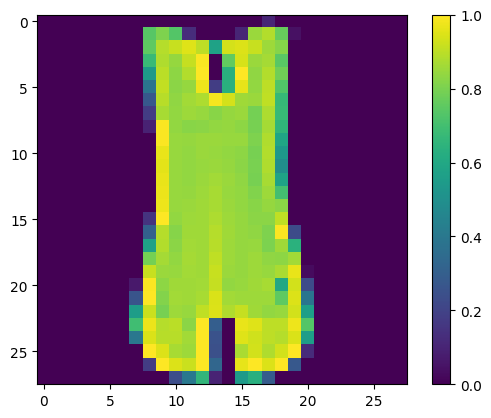

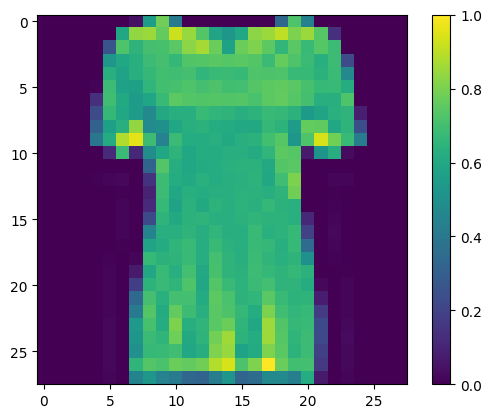

1.0


In [4]:
def show_image(image):
  plt.figure() # Create a new figure
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

this_pair = 4
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])
print(tr_y[this_pair])

## Define Base Network

In [5]:
def initialize_base_network():
  """Initialize Base Model"""
  input = Input(shape = (28, 28, ), name = "base_input")
  x = Flatten(name = "flatten_input")(input)
  x = Dense(128, activation = "relu", name = "first_base_dense")(x)
  x = Dropout(0.1, name = "first_dropout")(x)
  x = Dense(128, activation = "relu", name = "second_base_dense")(x)
  x = Dropout(0.1, name = "second_dropout")(x)
  x = Dense(128, activation = "relu", name = "third_base_dense")(x)
  return Model(inputs = input, outputs = x)

def euclidean_distance(vects):
  """Input: vecotrs
  Output: Euclidean Distance"""
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis = 1, keepdims = True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

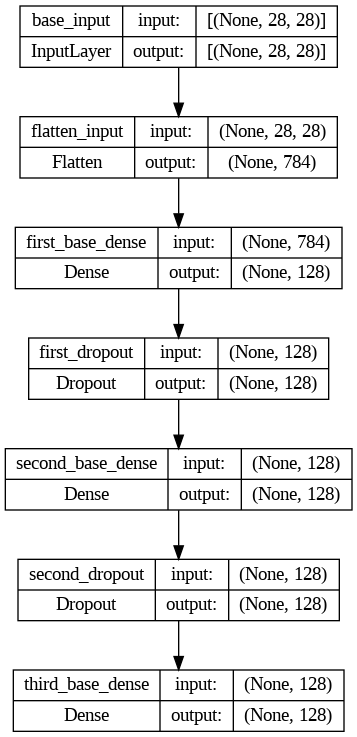

In [6]:
base_network = initialize_base_network()

plot_model(base_network, show_shapes = True)

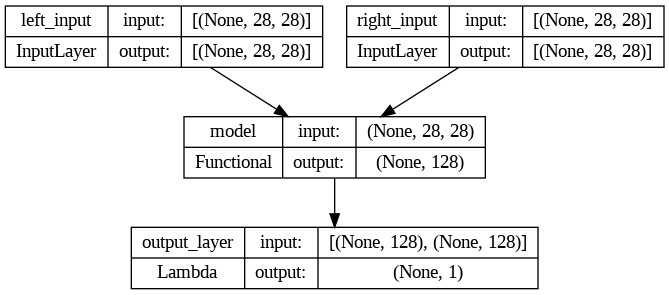

In [7]:
input_a = Input(shape = (28, 28,), name = "left_input")
vect_output_a = base_network(input_a)
input_b = Input(shape = (28, 28, ), name = "right_input")
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, name = "output_layer", output_shape = eucl_dist_output_shape)([vect_output_a, vect_output_b])
model = Model([input_a, input_b], output)

# Plot model graph
plot_model(model, show_shapes = True)

In [8]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    """Defining Contrastive Loss"""
    square_pred = K.square(y_pred)
    margin_square  = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss


In [11]:
rms = RMSprop()
model.compile(loss = contrastive_loss_with_margin(margin = 1), optimizer = rms)
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, epochs = 20, batch_size = 128, validation_data = ([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))
loss = model.evaluate(x = [ts_pairs[:, 0], ts_pairs[:, 1]], y = ts_y)

Epoch 1/20
938/938 [==============================] - 7s 7ms/step - loss: 0.1113 - val_loss: 0.0925
Epoch 2/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0817 - val_loss: 0.0781
Epoch 3/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0738 - val_loss: 0.0738
Epoch 4/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0684 - val_loss: 0.0691
Epoch 5/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0651 - val_loss: 0.0704
Epoch 6/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0630 - val_loss: 0.0669
Epoch 7/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0610 - val_loss: 0.0663
Epoch 8/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0594 - val_loss: 0.0654
Epoch 9/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0583 - val_loss: 0.0650
Epoch 10/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0569 - val_loss: 0.0636

## Evaluate Model

In [15]:
def compute_accuracy(y_true, y_pred):
  """Compute classification accuracy with a fixed threshold on distances."""
  pred = y_pred.ravel() > 0.5
  return np.mean(pred == y_true)


In [17]:
y_pred_train = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:, 0], ts_pairs[:, 1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)
print(f"Loss = {loss}, Train Accuracy = {train_accuracy}, Test Accuracy = {test_accuracy}")

625/625 [==============================] - 1s 2ms/step
Loss = 0.06322130560874939, Train Accuracy = 0.06278546424404068, Test Accuracy = 0.0891891891891892


## Plot Loss

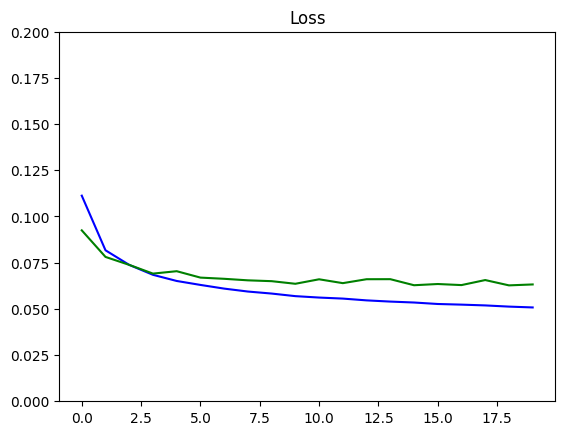

In [18]:
def plot_metrics(metric_name, title, ylim = 5):
  """"Plot metrics"""
  plt.title(title)
  plt.ylim(0, ylim)
  plt.plot(history.history[metric_name], color = "blue", label=metric_name)
  plt.plot(history.history['val_'+metric_name], color = "green", label="val_"+metric_name)

plot_metrics("loss", title = "Loss", ylim = 0.2)


## Visualize Images

In [22]:
def visualize_images():
  # Matplotlib config
  plt.rc('image', cmap = 'gray_r')
  plt.rc('grid', linewidth=0)
  plt.rc('xtick', top=False, bottom=False, labelsize='large')
  plt.rc('ytick', top=False, bottom=False, labelsize='large')
  plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor="white")
  plt.rc('text', color="a8151a")
  plt.rc("figure", facecolor="F0F0F0")

# Utility to display a row of digit with their predictions
def display_images(left, right, predictions, labels, title, n):
  plt.figure(figsize=(17, 3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  plt.grid(None)
  left=np.reshape(left, [n, 28, 28])
  left = np.swapaxes(left, 0, 1)
  left= np.reshape(left, [28, 28*n])
  plt.imshow(left)
  plt.figure(figsize=(17, 3))
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] > 0.5:
      t.set_color("red") # Wrong predictions in red
  plt.grid(None)
  right=np.reshape(right, [n, 28, 28])
  right = np.swapaxes(right, 0, 1)
  right= np.reshape(right, [28, 28*n])
  plt.imshow(right)

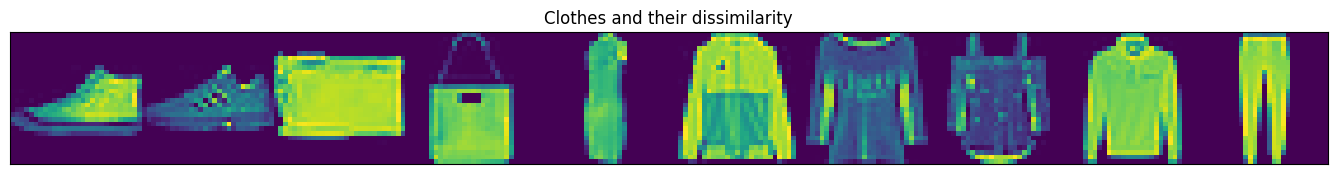

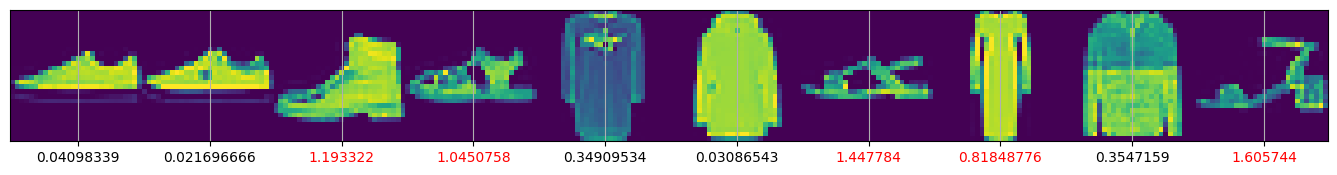

In [24]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size = 10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "Clothes and their dissimilarity", 10)

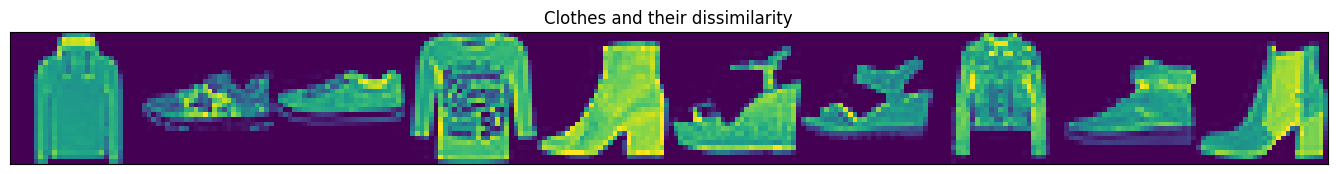

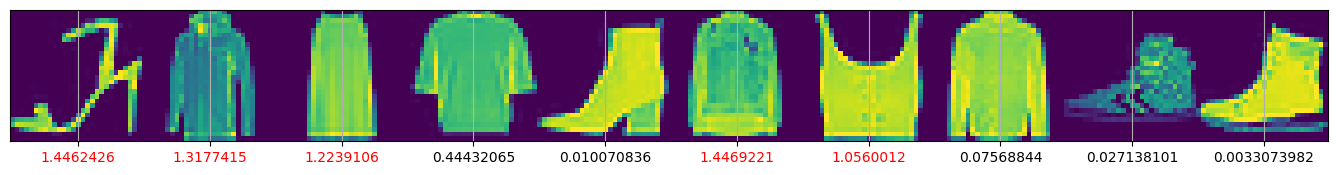

In [25]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size = 10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "Clothes and their dissimilarity", 10)

* The high values show images are dissimilar and low value represent the two images are similar

Course Reference: https://www.coursera.org/learn/custom-models-layers-loss-functions-with-tensorflow/home/week/5